# 02 Fine-tune SAM

Reference: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

## Set up Modelling Environment

In [1]:
# Install the required libraries
#SAM
%pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
%pip install transformers
#Datasets to prepare data and monai if you want to use special loss functions
%pip install datasets --user
%pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
%pip install patchify
#Rasterio
%pip install rasterio

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pbkiy7pr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pbkiy7pr
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=1f2cf28224793c35d9d22b76713295adc49c6aeee0d284d977c90a16c4cfb237
  Stored in directory: /tmp/pip-ephem-wheel-cache-fry5xxcz/wheels/6e/b2/38/082465c177a067501384fd15cb18be1128372ef60f27a1c426
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/5b/0b/e45d26ccd28568013523e04f325432ea88a442b4e3020b757cf4361f0120/transformers-4.30.2-py3-none-any.whl.metad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

## Prepare training datasets

In [3]:
# Read geo tiff files

In [4]:
def read_tiff(file_path):
    with rasterio.open(file_path) as src:
        return src.read()

In [5]:
images = read_tiff("satellite_images/validate/stack/images.tif")
masks = read_tiff("satellite_images/validate/stack/masks.tif")

In [6]:
images.shape

(10, 256, 256)

In [7]:
masks.shape

(10, 256, 256)

In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [9]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10
})

In [10]:
# Random check a set of image and mask

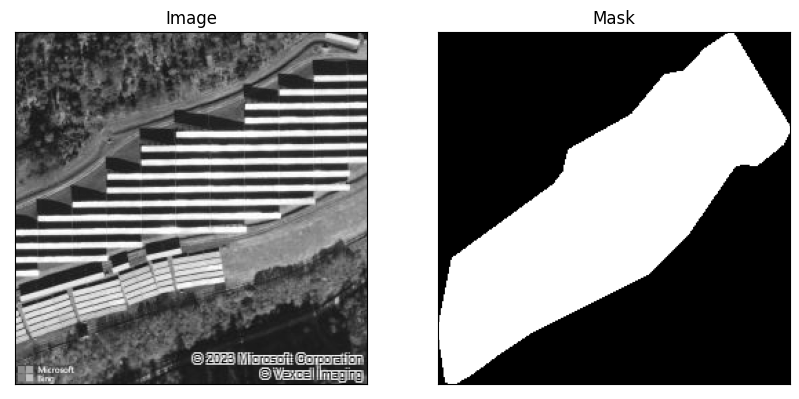

In [11]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [12]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [20]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [21]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [22]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [23]:
train_dataset

In [24]:
# Chech a set of example data
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Train SAM

In [25]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [26]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [27]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [28]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [29]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [30]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import time

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
    
    elapsed_time = (time.time() - start_time)/60  # Calculate elapsed time for the epoch
    
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Time taken for the epoch: {elapsed_time:.2f} minutes\n')

100%|██████████| 5/5 [02:02<00:00, 24.48s/it]

EPOCH: 0
Mean loss: 0.29589170813560484
Time taken for the epoch: 2.04 minutes



In [31]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "models/sam/10.pth")

In [ ]:
model_save_path = 'gs://c/' + 'test/model.pth'
print(model_save_path)
model.save_model(model_save_path)

In [35]:
import gcsfs
fs = gcsfs.GCSFileSystem(project = '<METER-SAM>')
with fs.open("gs://meter-sam/"+f'model/model.pth', 'wb') as f:
    torch.save(model, f)

In [ ]:
data_dir ='/gcs/meter-sam/'
images = read_tiff(data_dir + 'stack/image_500.tif')
masks = read_tiff(data_dir + 'stack/mask_500.tif')

# Apply fine-tuned SAM (**Inference**)

## Apply to training datasets

In [17]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [18]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
model.load_state_dict(torch.load("models/sam/101.pth"))

<All keys matched successfully>

In [19]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0): SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
      (1): SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Line

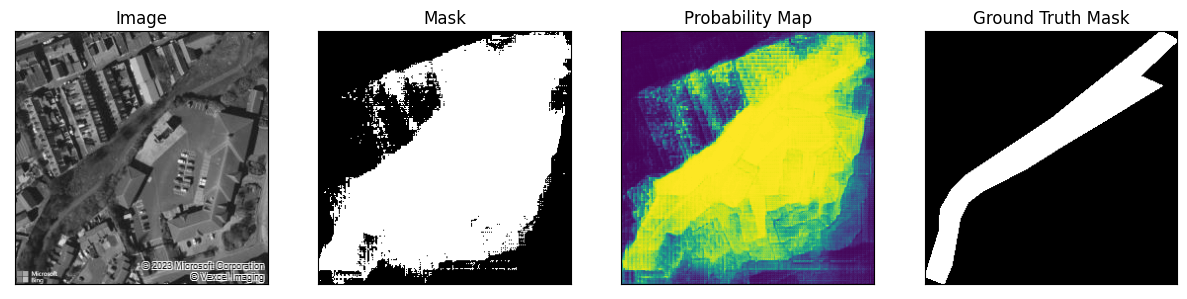

In [20]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(sam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the third image on the right
axes[2].imshow(sam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the fourth image on the left
axes[3].imshow(ground_truth_mask, cmap='gray')  # Assuming the first image is grayscale
axes[3].set_title("Ground Truth Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Prediction Accuracy: 55.06%


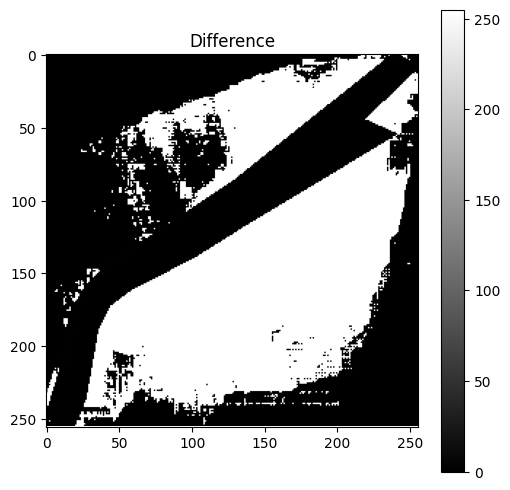

In [21]:
# Calculate prediction accuracy
correct_predictions = np.sum(sam_seg == ground_truth_mask)
total_pixels = sam_seg.size
accuracy = correct_predictions / total_pixels

print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

# Calculate the difference
difference = ground_truth_mask - sam_seg

# Plot the difference
plt.figure(figsize=(6, 6))
plt.imshow(difference, cmap='gray')
plt.title("Difference")
plt.colorbar()
plt.axis('on')
plt.show()

In [22]:
# Evaluate the mask prediction accuracy for each training dataset

In [23]:
def evaluate_mask_accuracy(idx, dataset, model, processor, device, get_bounding_box):
    """
    Evaluates the prediction for a given index from the dataset and visualizes the accuracy.

    Args:
    - idx (int): Index of the image in the dataset.
    - dataset: Dataset containing images and labels.
    - model: Trained model for prediction.
    - processor: Function to process the image and bounding box.
    - device: Device (e.g., 'cuda' or 'cpu') to which tensors should be moved.
    - get_bounding_box: Function to get bounding box from a mask.
    """

    # load image
    test_image = dataset[idx]["image"]

    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # apply sigmoid
    sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
    sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

    # Calculate prediction accuracy
    correct_predictions = np.sum(sam_seg == ground_truth_mask)
    total_pixels = sam_seg.size
    accuracy = correct_predictions / total_pixels

    print(str(idx) + " " + f"Prediction Accuracy: {accuracy * 100:.2f}%")

    # # Calculate the difference
    # difference = ground_truth_mask - sam_seg

    # # Plot the difference
    # plt.figure(figsize=(6, 6))
    # plt.imshow(difference, cmap='gray')
    # plt.title("Difference")
    # plt.colorbar()
    # plt.axis('on')
    # plt.show()

In [24]:
# idx = 2
# evaluate_mask_accuracy(idx, dataset, model, processor, device, get_bounding_box)

In [36]:
for idx in range(101):  # This will loop from 0 to 100 inclusive
    evaluate_mask_accuracy(idx, dataset, model, processor, device, get_bounding_box)

0 Prediction Accuracy: 72.00%
1 Prediction Accuracy: 82.65%
2 Prediction Accuracy: 72.28%
3 Prediction Accuracy: 77.01%
4 Prediction Accuracy: 84.43%
5 Prediction Accuracy: 42.73%
6 Prediction Accuracy: 65.66%
7 Prediction Accuracy: 68.74%
8 Prediction Accuracy: 49.92%
9 Prediction Accuracy: 72.78%
10 Prediction Accuracy: 54.06%
11 Prediction Accuracy: 79.35%
12 Prediction Accuracy: 80.23%
13 Prediction Accuracy: 80.30%
14 Prediction Accuracy: 73.48%
15 Prediction Accuracy: 73.80%
16 Prediction Accuracy: 77.44%
17 Prediction Accuracy: 81.90%
18 Prediction Accuracy: 68.63%
19 Prediction Accuracy: 55.21%
20 Prediction Accuracy: 74.81%
21 Prediction Accuracy: 57.64%
22 Prediction Accuracy: 66.25%
23 Prediction Accuracy: 77.39%
24 Prediction Accuracy: 72.49%
25 Prediction Accuracy: 62.52%
26 Prediction Accuracy: 42.58%
27 Prediction Accuracy: 76.86%
28 Prediction Accuracy: 85.12%
29 Prediction Accuracy: 73.37%
30 Prediction Accuracy: 71.34%
31 Prediction Accuracy: 85.01%
32 Prediction Accu

## Apply to valitating datasets

Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [25]:
#Apply a trained model
test_images = read_tiff("satellite_images/validate/stack/image_10.tif")
test_masks = read_tiff("satellite_images/validate/stack/mask_10.tif")

index=1
test_image = test_images[index]
test_mask = test_masks[index]
patches = patchify(test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

In [26]:
test_image.shape

(256, 256)

In [27]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [28]:
print(np.array(input_points).shape)

(1, 1, 100, 2)


In [29]:
patches.shape

(1, 1, 256, 256)

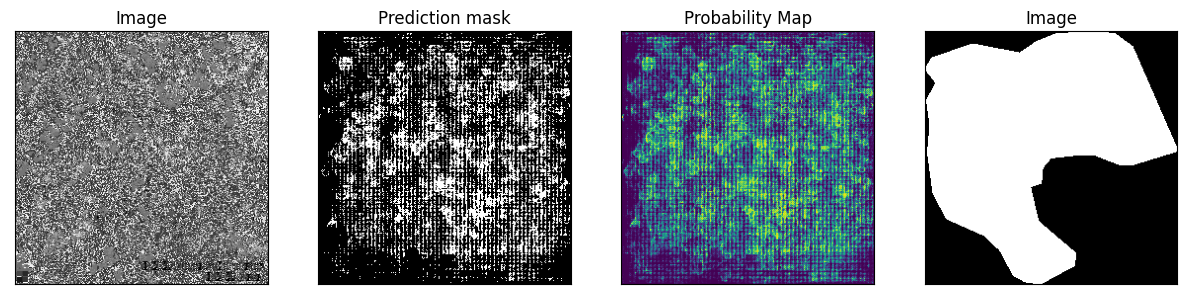

In [30]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

# #Or pick a specific patch for study.
i, j = 0, 0

# # Selectelected patch for segmentation
random_array = patches[i, j]

single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Prediction mask")

# Plot the thrid image on the right
axes[2].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the fourth image on the right
axes[3].imshow(np.array(test_mask), cmap='gray')  # Assuming the first image is grayscale
axes[3].set_title("Image")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Prediction Accuracy: 48.55%


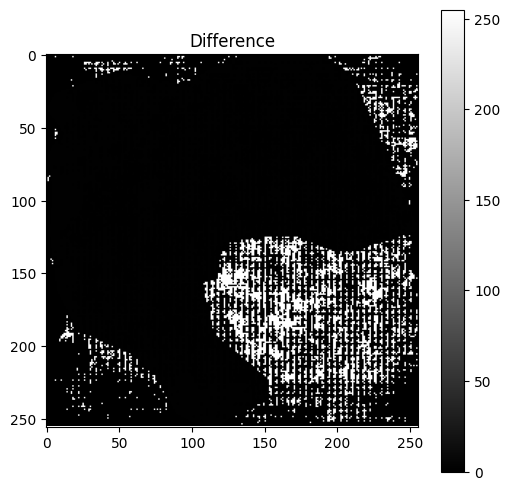

In [31]:
# Calculate prediction accuracy
correct_predictions = np.sum(single_patch_prediction == test_mask)
total_pixels = sam_seg.size
accuracy = correct_predictions / total_pixels

print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

# Calculate the difference
difference = test_mask - single_patch_prediction

# Plot the difference
plt.figure(figsize=(6, 6))
plt.imshow(difference, cmap='gray')
plt.title("Difference")
plt.colorbar()
plt.axis('on')
plt.show()

In [33]:
# Evaluate the mask prediction accuracy for each training dataset

def compare_mask_accuracy(index, model, processor, device, read_tiff, patchify, input_points):
    """
    Compares the mask prediction accuracy for a given index.

    Args:
    - index (int): Index of the image in the dataset.
    - model: Trained model for prediction.
    - processor: Function to process the image.
    - device: Device (e.g., 'cuda' or 'cpu') to which tensors should be moved.
    - read_tiff: Function to read TIFF images.
    - patchify: Function to create patches from an image.
    - input_points: Optional input points for the processor.
    """

    # Apply a trained model
    test_images = read_tiff("satellite_images/validate/stack/image_10.tif")
    test_masks = read_tiff("satellite_images/validate/stack/mask_10.tif")

    test_image = test_images[index]
    test_mask = test_masks[index]
    patches = patchify(test_image, (256, 256), step=256)  # Step=256 for 256 patches means no overlap

    # Or pick a specific patch for study.
    i, j = 0, 0

    # Select the selected patch for segmentation
    random_array = patches[i, j]

    single_patch = Image.fromarray(random_array)

    # Prepare image for the model
    inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # Apply sigmoid
    single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # Convert soft mask to hard mask
    single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
    single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

    # Calculate prediction accuracy
    correct_predictions = np.sum(single_patch_prediction == test_mask)
    total_pixels = single_patch_prediction.size
    accuracy = correct_predictions / total_pixels

    print(str(index) + " " + f"Prediction Accuracy: {accuracy * 100:.2f}%")

    # Calculate the difference
    difference = test_mask - single_patch_prediction

    # Plot the difference
    plt.figure(figsize=(6, 6))
    plt.imshow(difference, cmap='gray')
    plt.title("Difference")
    plt.colorbar()
    plt.axis('on')
    plt.show()

In [34]:
# index=2
# compare_mask_accuracy(index, model, processor, device, read_tiff, patchify, input_points)

0 Prediction Accuracy: 54.41%


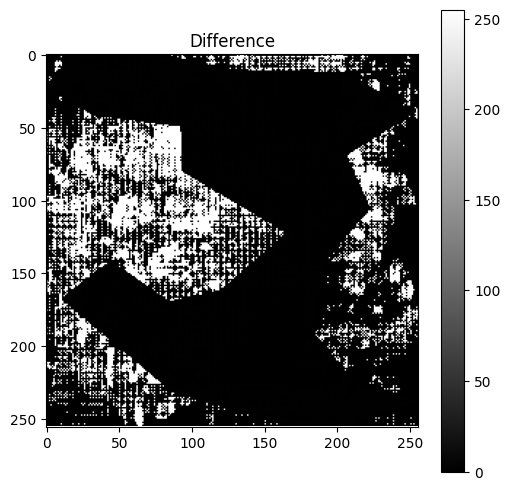

1 Prediction Accuracy: 48.55%


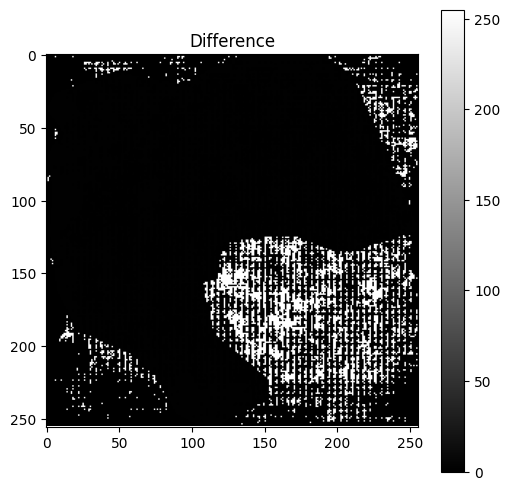

2 Prediction Accuracy: 68.35%


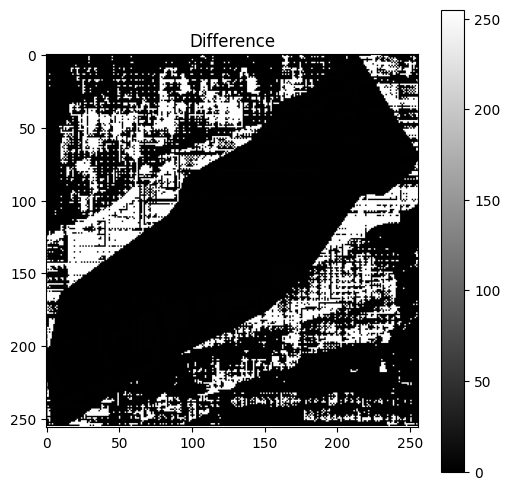

3 Prediction Accuracy: 51.98%


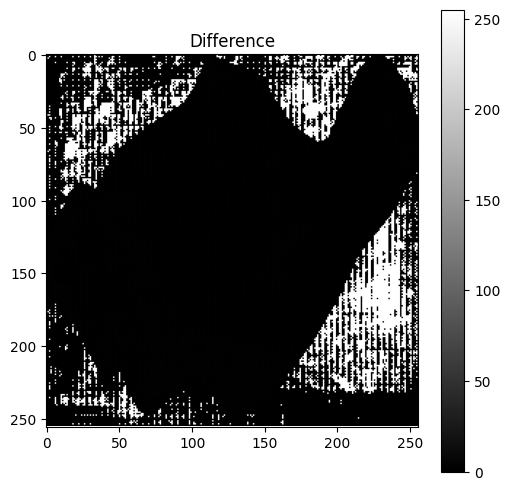

4 Prediction Accuracy: 53.41%


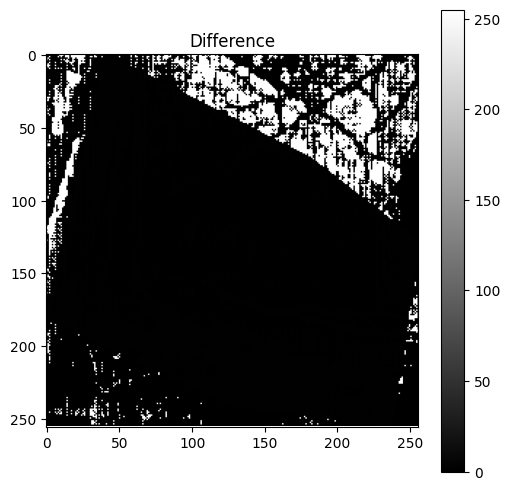

5 Prediction Accuracy: 60.80%


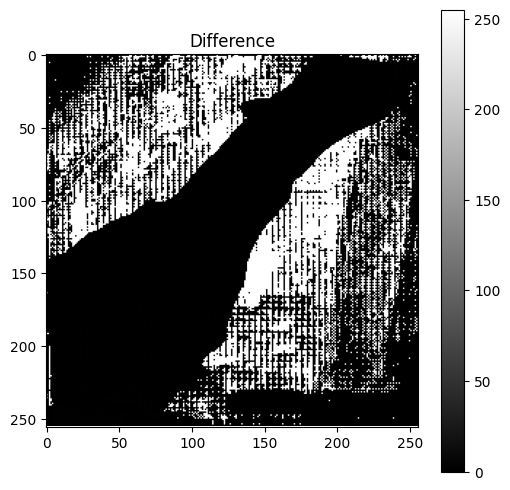

6 Prediction Accuracy: 61.02%


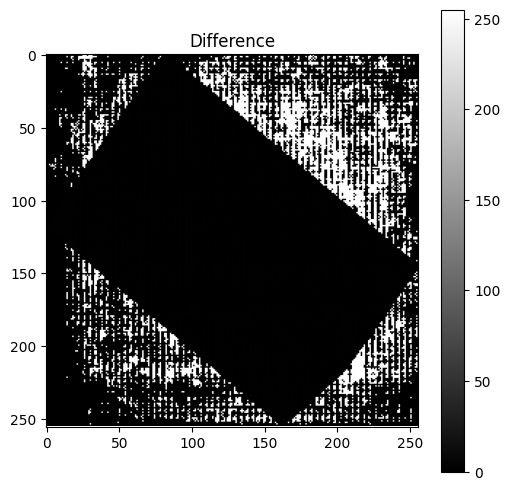

7 Prediction Accuracy: 60.82%


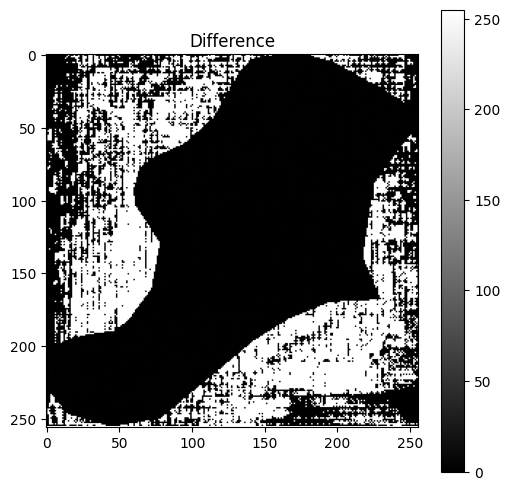

8 Prediction Accuracy: 61.46%


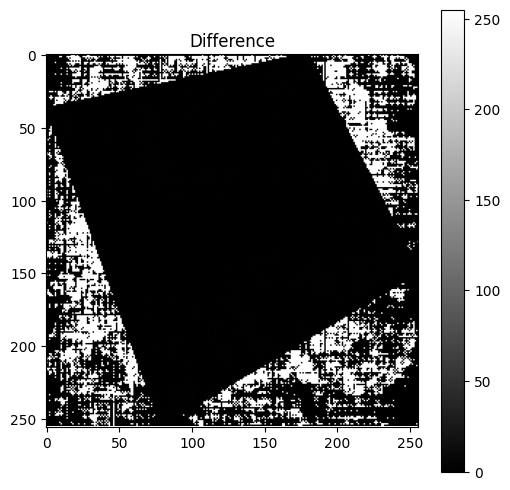

9 Prediction Accuracy: 59.51%


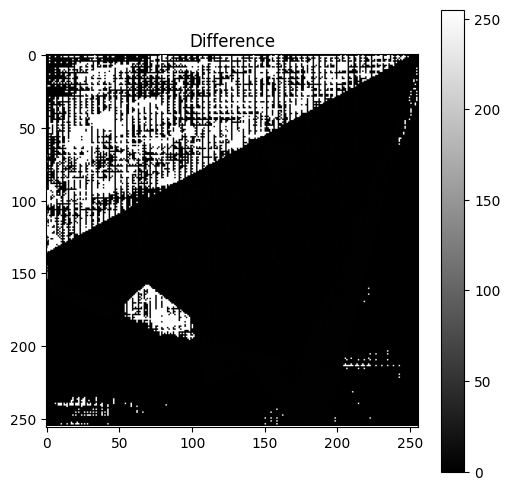

In [35]:
for index in range(10[]):  # This will loop from 0 to 10 inclusive
    compare_mask_accuracy(index, model, processor, device, read_tiff, patchify, input_points)